###EMANI BHARATH REDDY

In [ ]:
training_data_directory='train'
test_data_directory='test'

In [ ]:
import os
import re
import cv2
import time
import shutil
import zipfile
import urllib.request
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange 
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

**DATA**

In [ ]:

file = 'soil_photos.zip'
url = 'http://apmonitor.com/pds/uploads/Main/'+file
urllib.request.urlretrieve(url, file)
with zipfile.ZipFile(file, 'r') as zip_ref:
     zip_ref.extractall('./')
os.remove(file)

In [ ]:
# Initiate data processing tools
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

# Load data into Python
training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 75 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


**MODEL BUILDING**

In [ ]:

# choose model parameters
num_conv_layers = 2
num_dense_layers = 1
layer_size = 32
num_training_epochs = 20
MODEL_NAME = 'soil'

In [ ]:
# Initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convolutional layer
model.add(Conv2D(layer_size, (3, 3), input_shape=(256,256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# add output layer
model.add(Dense(3))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'],
                )

# use the data already loaded previously to train/tune the model
model.fit(training_data,
            epochs=num_training_epochs,
            validation_data = testing_data)

# save the trained model
model.save(f'{MODEL_NAME}.h5')

Epoch 1/20
3/3 [==============================] - 14s 5s/step - loss: 5.7614 - accuracy: 0.2933 - val_loss: 1.0907 - val_accuracy: 0.3333
Epoch 2/20
3/3 [==============================] - 7s 2s/step - loss: 1.3238 - accuracy: 0.3200 - val_loss: 1.2336 - val_accuracy: 0.3333
Epoch 3/20
3/3 [==============================] - 7s 3s/step - loss: 1.2273 - accuracy: 0.3067 - val_loss: 1.2075 - val_accuracy: 0.3333
Epoch 4/20
3/3 [==============================] - 7s 2s/step - loss: 1.1494 - accuracy: 0.4000 - val_loss: 1.1088 - val_accuracy: 0.5333
Epoch 5/20
3/3 [==============================] - 7s 3s/step - loss: 1.0942 - accuracy: 0.3467 - val_loss: 1.0873 - val_accuracy: 0.6000
Epoch 6/20
3/3 [==============================] - 7s 2s/step - loss: 1.0777 - accuracy: 0.4933 - val_loss: 1.0763 - val_accuracy: 0.6000
Epoch 7/20
3/3 [==============================] - 7s 2s/step - loss: 1.0691 - accuracy: 0.6400 - val_loss: 1.0668 - val_accuracy: 0.3333
Epoch 8/20
3/3 [========================

**Model Testing**

In [ ]:
def make_prediction(image_fp):
    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2,1,0]])
    img = image.load_img(image_fp, target_size = (256,256))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)
    
    class_ = ["Gravel", "Sand", "Silt"] # possible output values
    predicted_value = class_[model.predict(img_batch).argmax()]
    true_value = re.search(r'(Gravel)|(Sand)|(Silt)', image_fp)[0]
    
    out = f"""Predicted Soil Type: {predicted_value}
    True Soil Type: {true_value}
    Correct?: {predicted_value == true_value}"""
    
    return out

1/1 [==============================] - 0s 127ms/step
Predicted Soil Type: Sand
    True Soil Type: Sand
    Correct?: True


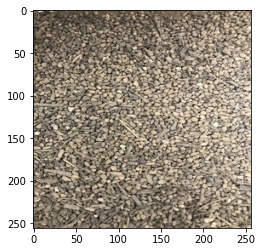

In [ ]:
test_image_filepath = test_data_directory + r'/Sand/0.jpg'
print(make_prediction(test_image_filepath))

**Soil Classification Percentages**

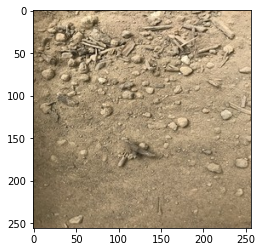

In [ ]:
percentage_photo = test_data_directory + r"/Silt/5.jpg"
im = cv2.imread(percentage_photo) # load image
plt.imshow(im[:,:,[2,1,0]])

**Data**

In [ ]:
def split_images(image_dir, save_dir):
    classification_list = ['Gravel', 'Sand', 'Silt']
    for classification in classification_list:
        folder = image_dir + '/' + classification + '/'
        save_folder = save_dir + '/' + classification + '/'
        files = [f for f in listdir(folder) if isfile(join(folder, f))]

        for file in files:
            if '.ini' in file:
                continue
            fp = folder + file
            img = cv2.imread(fp)
            h,w,c = img.shape
            im_dim = 64
            # For cropping images
            for r in range(0,img.shape[0],im_dim):
                for c in range(0,img.shape[1],im_dim):
                    cropped_img = img[r:r+im_dim, c:c+im_dim,:]
                    ch, cw, cc = cropped_img.shape
                    if ch == im_dim and cw == im_dim:
                        write_path = f"{save_folder + str(randrange(100000))}img{r}_{c}.jpg"
                        cv2.imwrite(write_path,cropped_img)
                    else:
                        pass

In [ ]:
try:
    parent = training_data_directory.replace('train', '')
    dirs = ['train_divided', 'test_divided']
    class_ = ["Gravel", "Sand", "Silt"]
    for dir in dirs:
        os.mkdir(os.path.join(parent, dir))
        for classification in class_:
            os.mkdir(os.path.join(parent, dir, classification))

    # split training images
    split_images(image_dir=training_data_directory,
                save_dir=training_data_directory.replace('train', 'train_divided'))
    # split test images
    split_images(image_dir=test_data_directory,
                save_dir=test_data_directory.replace('test', 'test_divided'))
except FileExistsError:
    pass

**Load Model**

In [ ]:
model_fp = os.getcwd()+'/'+'soil.h5'
print(model_fp)
model = load_model(model_fp)

/content/soil.h5


**Classify Image**

In [ ]:
def classify_images(image_fp, model):
    classes = ['Gravel', 'Sand', 'Silt']
    gravel_count = 0
    sand_count = 0
    silt_count = 0

    img = cv2.imread(image_fp)
    img = cv2.resize(img,(1024,1024))
    im_dim = 256

    for r in range(0, img.shape[0], im_dim):
        for c in range(0, img.shape[1], im_dim):
            cropped_img = img[r:r + im_dim, c:c + im_dim, :]
            h, w, c = cropped_img.shape
            if h == im_dim and w == im_dim:
                classification = model_classify(cropped_img, model)
                if classification == classes[0]:
                    gravel_count += 1
                elif classification == classes[1]:
                    sand_count += 1
                elif classification == classes[2]:
                    silt_count += 1
            else:
                continue
    total_count = gravel_count + sand_count + silt_count
    proportion_array = [gravel_count / total_count, sand_count / total_count, silt_count / total_count]
    return proportion_array


def model_classify(cropped_img, model):
    classes = ['Gravel', 'Sand', 'Silt']
    image_array = cropped_img / 255.
    img_batch = np.expand_dims(image_array, axis=0)
    prediction_array = model.predict(img_batch)[0]
    first_idx = np.argmax(prediction_array)
    first_class = classes[first_idx]
    return first_class

def classify_percentage(image_fp):
    start = time.time()
    out = classify_images(image_fp=image_fp, model=model)
    finish = str(round(time.time() - start, 5))
    
    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2, 1, 0]])

    print(f'''---
Percent Gravel: {round(out[0] * 100, 2)}%)
Percent Sand: {round(out[1] * 100, 2)}%)
Percent Silt: {round(out[2] * 100, 2)}%)
Time to Classify: {finish} seconds
---''')

1/1 [==============================] - 0s 38ms/step
---
Percent Gravel: 100.0%)
Percent Sand: 0.0%)
Percent Silt: 0.0%)
Time to Classify: 1.31208 seconds
---


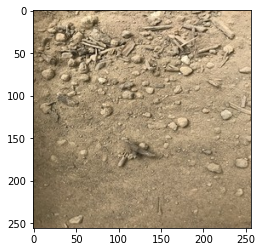

In [ ]:
classify_percentage(image_fp=percentage_photo)